# Tanmay Garg
## CS20BTECH11063
## Deep Learning Assignment 5

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
import PIL
from PIL import Image
# import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

np.random.seed(0)
torch.cuda.is_available()

/home/cs20btech11063/anaconda3/envs/gpu_env2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## MNIST Dataset

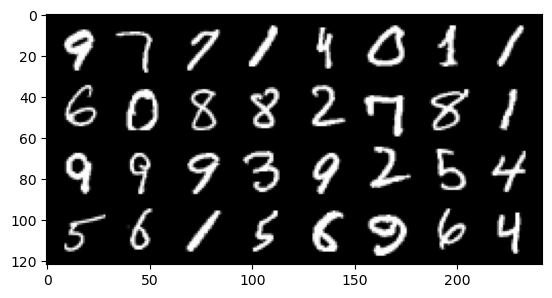

    9     7     7     1     4     0     1     1     6     0     8     8     2     7     8     1     9     9     9     3     9     2     5     4     5     6     1     5     6     9     6     4


In [2]:
# MNIST Dataset Loader

def get_mnist_data(batch_size=32, shuffle=True):
    transform = transforms.Compose([
                                    transforms.ToTensor(), 
                                    # transforms.Normalize((0.1307,), (0.3081,))
                                ])
    
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

# Data Loader
train_ds, test_ds, train_dl, test_dl = get_mnist_data(batch_size=32, shuffle=True)

# Visualize the data
def show_image(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    plt.close()

# Get some random training images
dataiter = iter(train_dl)
images, labels = dataiter.next()

# Show images
show_image(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(32)))

def denormalize(img):
    transform = transforms.Compose([
                                    transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))
                                ])
    return transform(img)

## Autoencoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, hidden_dim),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid()
            )     

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
    #     self.to(device)
    #     train_loss = []
    #     test_loss = []
    #     for epoch in range(epochs):
    #         train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
    #         test_loss.append(self.test_model(test_loader, criterion, device))
    #         print('Epoch: {}/{}\t Train Loss: {:.6f}\t Test Loss: {:.6f}'.format(epoch+1, epochs, train_loss[-1], test_loss[-1]))
        
    #     return train_loss, test_loss
    
    # def train_epoch(self, train_loader, optimizer, criterion, device):
    #     train_loss = 0.0
    #     self.train()
    #     for batch_idx, data in enumerate(train_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         optimizer.zero_grad()
    #         outputs = self(inputs)
    #         loss = criterion(outputs, inputs)
    #         loss.backward()
    #         optimizer.step()
            
    #         train_loss += loss.item()
            
    #     train_loss = train_loss / len(train_loader)
        
    #     return train_loss
    
    # def test_model(self, test_loader, criterion, device):
    #     test_loss = 0.0
    #     self.eval()
    #     for batch_idx, data in enumerate(test_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         outputs = self(inputs)
    #         loss = criterion(outputs, inputs)
            
    #         test_loss += loss.item()
            
    #     test_loss = test_loss / len(test_loader)
        
    #     return test_loss
    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device)
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_model(test_loader, criterion, device))
            print(f'Epoch: {epoch+1}/{epochs}\t Train Loss: {train_loss[-1]:.6f}\t Test Loss: {test_loss[-1]:.6f}')
        
        return train_loss, test_loss

    def train_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        self.train()
        for batch_idx, data in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        return train_loss

    def test_model(self, test_loader, criterion, device):
        test_loss = 0.0
        self.eval()
        for batch_idx, data in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs = self(inputs)
            loss = criterion(outputs, inputs)
            
            test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        
        return test_loss

def display_reconstructions(model, test_loader, device):
    model.eval()
    dataiter = iter(test_loader)
    # dataiter.next()
    images, labels = dataiter.next()
    images = images.to(device)
    input_img = images
    images = images.view(images.size(0), -1)
    outputs = model(images)
    outputs = outputs.view(outputs.size(0), 1, 28, 28)
    outputs = outputs.cpu()
    # print(outputs.shape)
    # print(input_img.shape)
    print("Reconstructed Images:")
    show_image(torchvision.utils.make_grid(outputs.detach().cpu()))
    print("Original Images:")
    show_image(torchvision.utils.make_grid(input_img.detach().cpu()))
    return

def latent_space_gen(model, input_img1, input_img2, device, num_samples=10):
    model.eval()
    input_img1 = input_img1.to(device)
    input_img2 = input_img2.to(device)
    input_img1 = input_img1.view(input_img1.size(0), -1)
    input_img2 = input_img2.view(input_img2.size(0), -1)
    output_img1 = model.encoder(input_img1)
    output_img2 = model.encoder(input_img2)
    
    sampled_imgs = []
    for alpha in np.linspace(0, 1, num_samples):
        sampled_img = output_img1 + alpha * (output_img2 - output_img1)
        sampled_img = model.decoder(sampled_img)
        sampled_img = sampled_img.view(sampled_img.size(0), 1, 28, 28)
        sampled_imgs.append(sampled_img)
    
    sampled_imgs = torch.cat(sampled_imgs, dim=0)
    sampled_imgs = sampled_imgs.cpu()
    # show_image(torchvision.utils.make_grid(sampled_imgs.detach()))
    return sampled_imgs


==========Training AutoEncoder with hidden dimension = 32==========


Epoch: 1/10	 Train Loss: 0.030254	 Test Loss: 0.017036


Epoch: 2/10	 Train Loss: 0.015034	 Test Loss: 0.013102


Epoch: 3/10	 Train Loss: 0.012773	 Test Loss: 0.011971


Epoch: 4/10	 Train Loss: 0.011737	 Test Loss: 0.011240


Epoch: 5/10	 Train Loss: 0.011060	 Test Loss: 0.010530


Epoch: 6/10	 Train Loss: 0.010574	 Test Loss: 0.010126


Epoch: 7/10	 Train Loss: 0.010195	 Test Loss: 0.009973


Epoch: 8/10	 Train Loss: 0.009893	 Test Loss: 0.009581


Epoch: 9/10	 Train Loss: 0.009652	 Test Loss: 0.009417


Epoch: 10/10	 Train Loss: 0.009446	 Test Loss: 0.009217
==========Reconstruction of the images from the test set==========
Reconstructed Images:


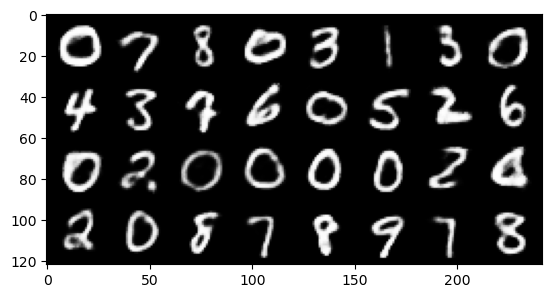

Original Images:


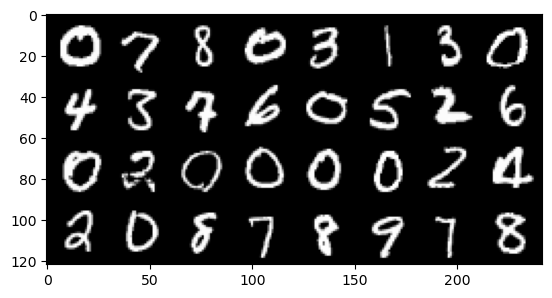

==========Reconstruction of the images from the train set==========
Reconstructed Images:


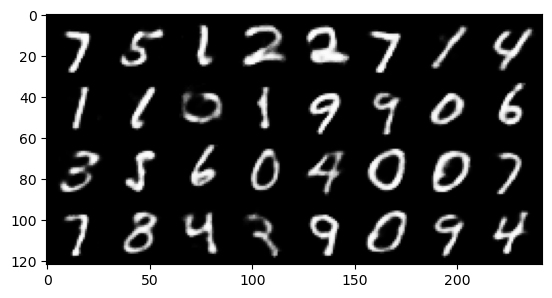

Original Images:


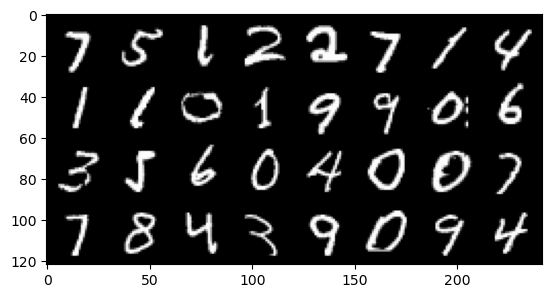

==========Reconstruction of the images from the latent space==========


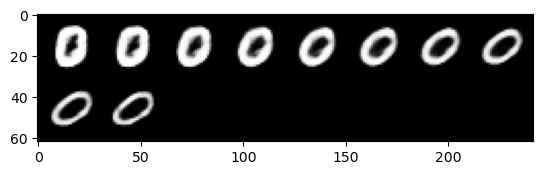

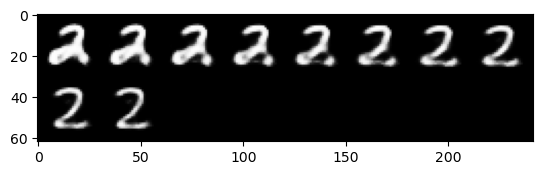

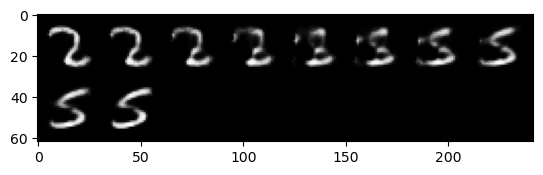

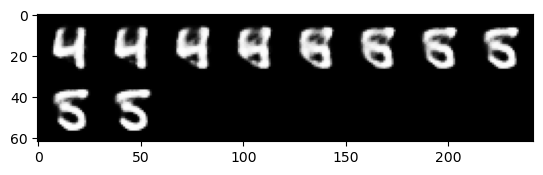

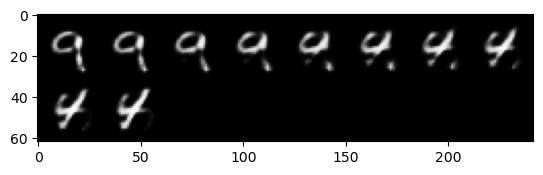

In [4]:
AutoEn_32  = AutoEncoder(hidden_dim=32)
optimizer = optim.Adam(AutoEn_32.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 32==========")
train_loss, test_loss = AutoEn_32.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

print("==========Reconstruction of the images from the test set==========")
display_reconstructions(AutoEn_32, test_dl, device)

print("==========Reconstruction of the images from the train set==========")
display_reconstructions(AutoEn_32, train_dl, device)

# Taking random images and reconstructing images from a random point which is in between the two samples in the latent space
print("==========Reconstruction of the images from the latent space==========")
num_pairs = 5
for i in range(num_pairs):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    sampled_imgs = latent_space_gen(AutoEn_32, images[0], images[1], device)
    show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

    

==========Training AutoEncoder with hidden dimension = 64==========


Epoch: 1/10	 Train Loss: 0.028496	 Test Loss: 0.014555


Epoch: 2/10	 Train Loss: 0.012167	 Test Loss: 0.010338


Epoch: 3/10	 Train Loss: 0.009500	 Test Loss: 0.008412


Epoch: 4/10	 Train Loss: 0.008072	 Test Loss: 0.007264


Epoch: 5/10	 Train Loss: 0.007143	 Test Loss: 0.006548


Epoch: 6/10	 Train Loss: 0.006566	 Test Loss: 0.006235


Epoch: 7/10	 Train Loss: 0.006159	 Test Loss: 0.005701


Epoch: 8/10	 Train Loss: 0.005840	 Test Loss: 0.005628


Epoch: 9/10	 Train Loss: 0.005589	 Test Loss: 0.005314


Epoch: 10/10	 Train Loss: 0.005381	 Test Loss: 0.005231
==========Reconstruction of the images from the test set==========
Reconstructed Images:


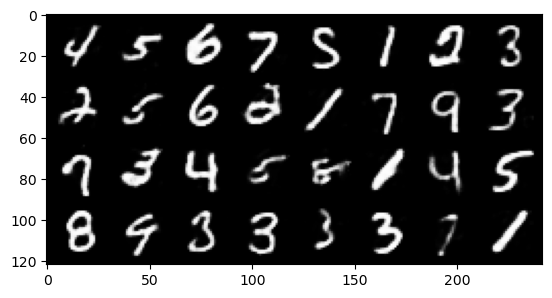

Original Images:


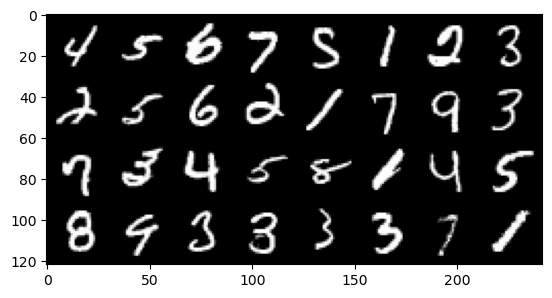

==========Reconstruction of the images from the train set==========
Reconstructed Images:


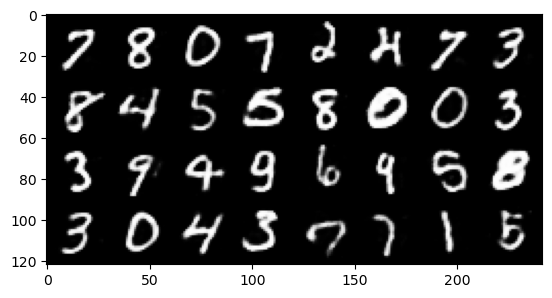

Original Images:


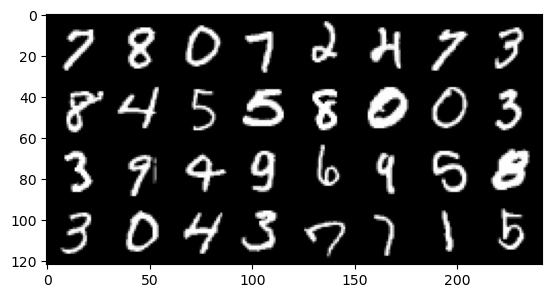

==========Reconstruction of the images from the latent space==========


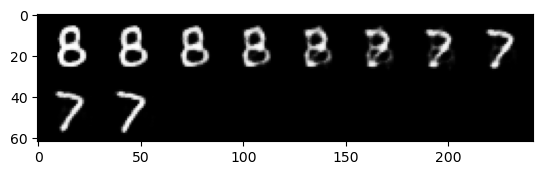

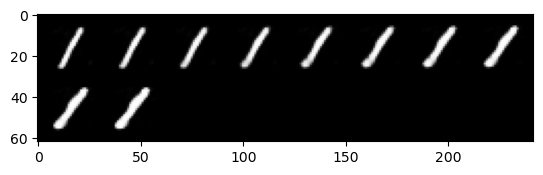

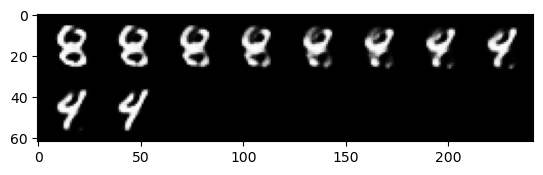

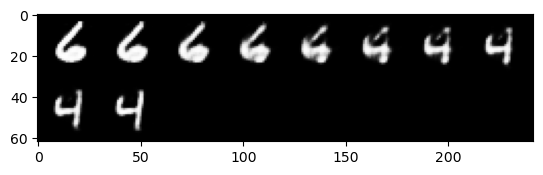

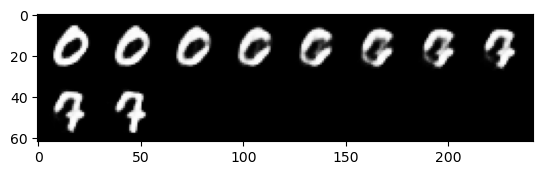

In [5]:
AutoEn_64  = AutoEncoder(hidden_dim=64)
optimizer = optim.Adam(AutoEn_64.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 64==========")
train_loss, test_loss = AutoEn_64.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

print("==========Reconstruction of the images from the test set==========")
display_reconstructions(AutoEn_64, test_dl, device)

print("==========Reconstruction of the images from the train set==========")
display_reconstructions(AutoEn_64, train_dl, device)

# Taking random images and reconstructing images from a random point which is in between the two samples in the latent space
print("==========Reconstruction of the images from the latent space==========")
num_pairs = 5
for i in range(num_pairs):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    sampled_imgs = latent_space_gen(AutoEn_64, images[0], images[1], device)
    show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

    
# AutoEn_64  = AutoEncoder(hidden_dim=64)
# optimizer = optim.Adam(AutoEn_64.parameters(), lr=0.001)
# criterion = nn.MSELoss()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# train_loss, test_loss = AutoEn_64.train_AutoEn_64(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

# display_reconstructions(AutoEn_64, test_dl, device)
# display_reconstructions(AutoEn_64, train_dl, device)

# num_pairs = 5
# for i in range(num_pairs):
#     dataiter = iter(test_dl)
#     images, labels = dataiter.next()
#     sampled_imgs = latent_space_gen(AutoEn_64, images[0], images[1], device)
#     show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

==========Training AutoEncoder with hidden dimension = 32 with weight decay==========


Epoch: 1/10	 Train Loss: 0.040965	 Test Loss: 0.029699


Epoch: 2/10	 Train Loss: 0.028294	 Test Loss: 0.026645


Epoch: 3/10	 Train Loss: 0.026896	 Test Loss: 0.026085


Epoch: 4/10	 Train Loss: 0.026456	 Test Loss: 0.025610


Epoch: 5/10	 Train Loss: 0.026237	 Test Loss: 0.025567


Epoch: 6/10	 Train Loss: 0.026082	 Test Loss: 0.025510


Epoch: 7/10	 Train Loss: 0.025949	 Test Loss: 0.025360


Epoch: 8/10	 Train Loss: 0.025790	 Test Loss: 0.025053


Epoch: 9/10	 Train Loss: 0.025211	 Test Loss: 0.024467


Epoch: 10/10	 Train Loss: 0.024940	 Test Loss: 0.024461
==========Reconstruction of the images from the test set==========
Reconstructed Images:


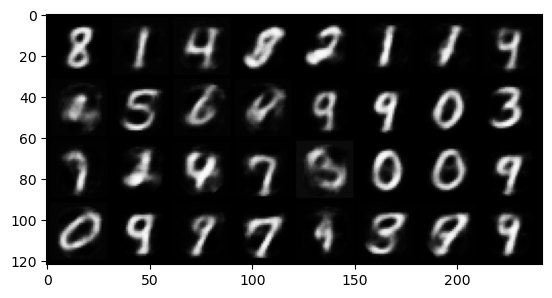

Original Images:


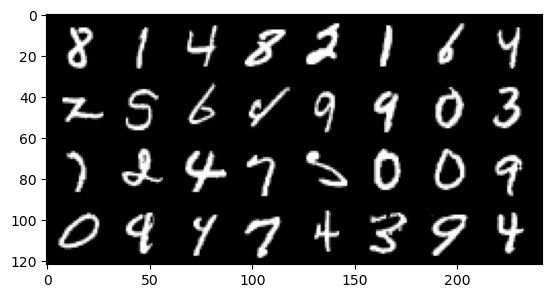

==========Reconstruction of the images from the train set==========
Reconstructed Images:


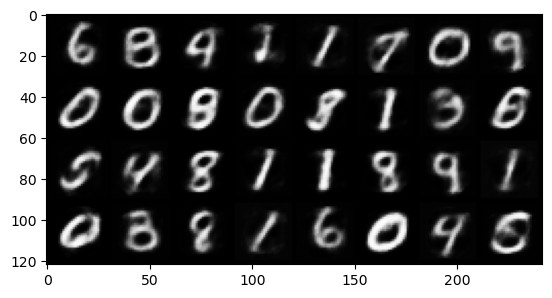

Original Images:


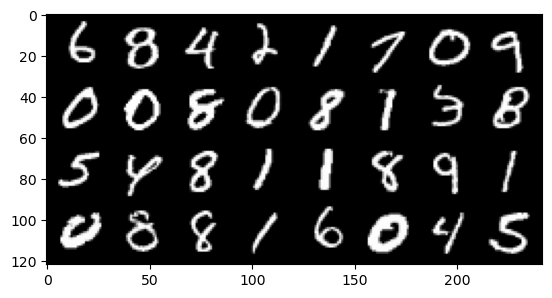

==========Reconstruction of the images from the latent space==========


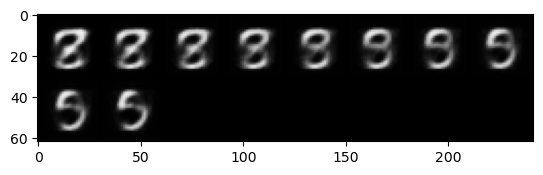

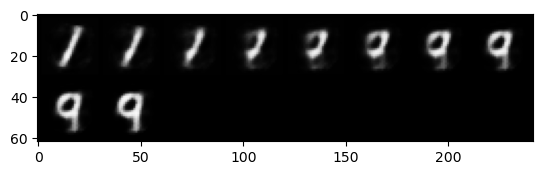

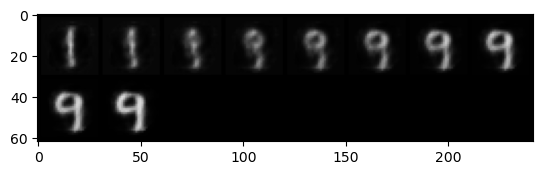

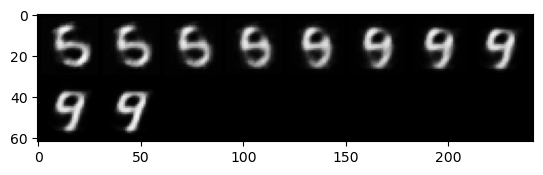

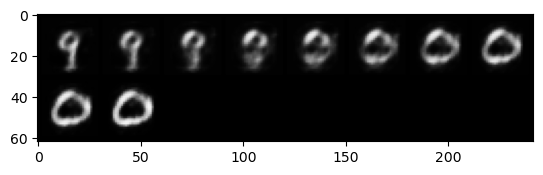

In [6]:
AutoEn_32_reg  = AutoEncoder(hidden_dim=32)
optimizer = optim.Adam(AutoEn_32_reg.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 32 with weight decay==========")
train_loss, test_loss = AutoEn_32_reg.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

print("==========Reconstruction of the images from the test set==========")
display_reconstructions(AutoEn_32_reg, test_dl, device)

print("==========Reconstruction of the images from the train set==========")
display_reconstructions(AutoEn_32_reg, train_dl, device)

# Taking random images and reconstructing images from a random point which is in between the two samples in the latent space
print("==========Reconstruction of the images from the latent space==========")
num_pairs = 5
for i in range(num_pairs):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    sampled_imgs = latent_space_gen(AutoEn_32_reg, images[0], images[1], device)
    show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

    

## Variational Autoencoder

In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid()    
            )
        
        self.fc_mu = nn.Linear(128, hidden_dim)
        self.fc_var = nn.Linear(128, hidden_dim)
        
    def sampling_method(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        var = self.fc_var(x)
        z = self.sampling_method(mu, var)
        x = self.decoder(z)
        return x, mu, var
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
    #     self.to(device)
    #     train_loss = []
    #     test_loss = []
    #     for epoch in range(epochs):
    #         train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
    #         test_loss.append(self.test_model(test_loader, criterion, device))
    #         print('Epoch: {}/{}\t Train Loss: {:.6f}\t Test Loss: {:.6f}'.format(epoch+1, epochs, train_loss[-1], test_loss[-1]))
        
    #     return train_loss, test_loss
    
    # # def train_epoch(self, train_loader, optimizer, criterion, device):
    # #     train_loss = 0.0
    # #     self.train()
    # #     for batch_idx, data in enumerate(train_loader):
    # #         inputs, labels = data
            
    # #         inputs = inputs.to(device)
    # #         inputs = inputs.view(inputs.size(0), -1)
            
    # #         optimizer.zero_grad()
    # #         outputs, mu, var = self(inputs)
    # #         loss = criterion(outputs, inputs, mu, var)
    # #         loss.backward()
    # #         optimizer.step()
            
    # #         train_loss += loss.item()
            
    # #     train_loss = train_loss / len(train_loader)
        
    # #     return train_loss
    
    # def train_epoch(self, train_loader, optimizer, criterion, device):
    #     train_loss = 0.0
    #     self.train()
    #     for batch_idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         optimizer.zero_grad()
    #         outputs, mu, var = self(inputs)
    #         loss = criterion(outputs, inputs, mu, var)
    #         loss.backward()
    #         optimizer.step()
            
    #         train_loss += loss.item()
            
    #     train_loss = train_loss / len(train_loader)
        
    #     return train_loss

    # def test_model(self, test_loader, criterion, device):
    #     test_loss = 0.0
    #     self.eval()
    #     for batch_idx, data in enumerate(test_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         outputs, mu, var = self(inputs)
    #         loss = criterion(outputs, inputs, mu, var)
            
    #         test_loss += loss.item()
            
    #     test_loss = test_loss / len(test_loader)
        
    #     return test_loss
    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device)
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_model(test_loader, criterion, device))
            print(f'Epoch: {epoch+1}/{epochs}\t Train Loss: {train_loss[-1]:.6f}\t Test Loss: {test_loss[-1]:.6f}')
        
        return train_loss, test_loss

    def train_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        self.train()
        for batch_idx, data in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            optimizer.zero_grad()
            outputs, mu, var = self(inputs)
            loss = criterion(outputs, inputs, mu, var)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        return train_loss

    def test_model(self, test_loader, criterion, device):
        test_loss = 0.0
        self.eval()
        for batch_idx, data in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs, mu, var = self(inputs)
            loss = criterion(outputs, inputs, mu, var)
            
            test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        
        return test_loss


# def vae_loss(recontruction, x, mu, var):
#     reconstruc_loss = torch.nn.functional.mse_loss(recontruction, x)
#     kl_div_loss = -0.5 * torch.sum(1 + var - (mu ** 2) - var.exp(), dim=1)
#     kl_div_loss = torch.mean(kl_div_loss)
    
#     total_loss = reconstruc_loss + kl_div_loss
#     return total_loss
def vae_loss(recontruction, x, mu, var):
    reconstruc_loss_class = nn.MSELoss(reduction='sum')
    reconstruc_loss = reconstruc_loss_class(recontruction, x)
    kl_div_loss = -0.5 * torch.sum(1 + var - (mu ** 2) - var.exp(), dim=1)
    kl_div_loss = torch.mean(kl_div_loss)
    
    total_loss = reconstruc_loss + kl_div_loss
    return total_loss


def display_reconstructions(model, test_loader, device):
    model.eval()
    dataiter = iter(test_loader)
    # dataiter.next()
    images, labels = dataiter.next()
    images = images.to(device)
    input_img = images
    images = images.view(images.size(0), -1)
    outputs, mu, var = model(images)
    outputs = outputs.view(outputs.size(0), 1, 28, 28)
    outputs = outputs.cpu()
    # print(outputs.shape)
    # print(input_img.shape)
    show_image(torchvision.utils.make_grid(outputs.detach()))
    show_image(torchvision.utils.make_grid(input_img.detach().cpu()))
     
        

Epoch: 1/20	 Train Loss: 830.548529	 Test Loss: 486.029274


Epoch: 2/20	 Train Loss: 440.461307	 Test Loss: 390.048139


Epoch: 3/20	 Train Loss: 376.067975	 Test Loss: 355.327209


Epoch: 4/20	 Train Loss: 347.308628	 Test Loss: 330.920821


Epoch: 5/20	 Train Loss: 329.652619	 Test Loss: 319.746312


Epoch: 6/20	 Train Loss: 317.545640	 Test Loss: 310.922786


Epoch: 7/20	 Train Loss: 308.717248	 Test Loss: 305.843884


Epoch: 8/20	 Train Loss: 301.451437	 Test Loss: 297.710805


Epoch: 9/20	 Train Loss: 296.269249	 Test Loss: 298.882469


Epoch: 10/20	 Train Loss: 291.393726	 Test Loss: 292.126318


Epoch: 11/20	 Train Loss: 287.347529	 Test Loss: 291.789980


Epoch: 12/20	 Train Loss: 284.224754	 Test Loss: 285.598555


Epoch: 13/20	 Train Loss: 280.831868	 Test Loss: 284.533114


Epoch: 14/20	 Train Loss: 278.801966	 Test Loss: 285.045370


Epoch: 15/20	 Train Loss: 276.138580	 Test Loss: 279.551274


Epoch: 16/20	 Train Loss: 273.925113	 Test Loss: 282.164150


Epoch: 17/20	 Train Loss: 271.899593	 Test Loss: 278.357202


Epoch: 18/20	 Train Loss: 270.224099	 Test Loss: 279.696848


Epoch: 19/20	 Train Loss: 268.610604	 Test Loss: 277.685361


Epoch: 20/20	 Train Loss: 267.133461	 Test Loss: 277.179668
==========Reconstruction of images from test set==========


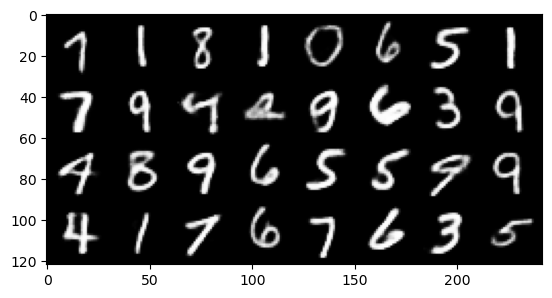

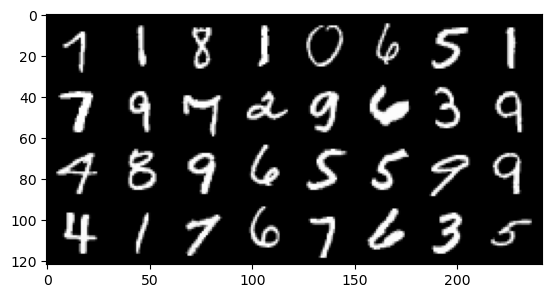

In [8]:
vae_model = VariationalAutoEncoder(hidden_dim=16)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
criterion = vae_loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loss, test_loss = vae_model.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=20, lr=0.001)

print("==========Reconstruction of images from test set==========")
display_reconstructions(vae_model, test_dl, device)

==========Randomly generated images==========


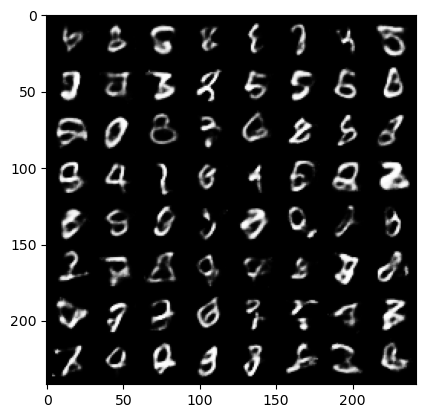

In [9]:
# randomly generate a sample from the latent space
def generate_sample(model, device):
    model.eval()
    z = torch.randn(1, 16).to(device)
    output = model.decoder(z)
    output = output.view(output.size(0), 1, 28, 28)
    output = output.cpu()
    # show_image(torchvision.utils.make_grid(output.detach()))
    return output.detach()

print("==========Randomly generated images==========")

gen_img_list = []
for i in range(64):
    gen_img_list.append(generate_sample(vae_model, device).squeeze(0))

show_image(torchvision.utils.make_grid(gen_img_list))

## Self Attention

In [10]:
# Loading CIFAR10 dataset

def load_cifar10(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader, trainset, testset

train_dl, test_dl, train_set, test_set = load_cifar10(batch_size=32)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim
        self.f = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.g = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.h = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        N, C, W, H = x.size()
        f_x = self.f(x).view(N, -1, W*H).permute(0, 2, 1)
        g_x = self.g(x).view(N, -1, W*H)
        h_x = self.h(x).view(N, -1, W*H)
        
        attention_map = torch.bmm(f_x, g_x)
        attention_map = self.softmax(attention_map)
        
        output = torch.bmm(h_x, attention_map.permute(0, 2, 1))
        
        output = output.view(N, C, W, H)
        output = self.gamma * output + x
        return output
    
class SelfAttentionCNN(nn.Module):
    # def __init__(self, in_dim=128):
    #     super(SelfAttentionCNN, self).__init__()
        
    #     self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    #     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    #     self.conv3 = nn.Conv2d(in_channels=64, out_channels=in_dim, kernel_size=3, stride=1, padding=1)
    #     self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    #     self.fc1 = nn.Linear(in_dim*4*4, 512)
    #     self.fc2 = nn.Linear(512, 10)
    #     self.attention_layer = SelfAttention(in_dim=in_dim)
    
    # def forward(self, x):
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.conv1(x))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.conv2(x))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.conv3(x))
    #     # print(x.shape)
    #     x = self.attention_layer(x)
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     x = x.view(-1, 128*4*4)
    #     x = torch.nn.functional.relu(self.fc1(x))
    #     x = self.fc2(x)
    #     return x
    
    # def __init__(self, in_dim=128):
    #     super(SelfAttentionCNN, self).__init__()

    #     self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    #     self.bn1 = nn.BatchNorm2d(32)
    #     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    #     self.bn2 = nn.BatchNorm2d(64)
    #     self.conv3 = nn.Conv2d(in_channels=64, out_channels=in_dim, kernel_size=3, stride=1, padding=1)
    #     self.bn3 = nn.BatchNorm2d(in_dim)
    #     self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    #     self.fc1 = nn.Linear(in_dim * 4 * 4, 512)
    #     self.dropout = nn.Dropout(0.5)
    #     self.fc2 = nn.Linear(512, 10)
    #     self.attention_layer1 = SelfAttention(in_dim=in_dim)
    #     self.attention_layer2 = SelfAttention(in_dim=in_dim)
    #     self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((4, 4))


    # def forward(self, x):
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
    #     # print(x.shape)
    #     x = self.attention_layer1(x)
    #     # print(x.shape)
    #     x = self.attention_layer2(x)
    #     # print(x.shape)
    #     x = self.adaptive_avg_pool(x)
    #     # print(x.shape)
    #     x = x.view(-1, 128 * 4 * 4)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.fc1(x))
    #     # print(x.shape)
    #     x = self.dropout(x)
    #     # print(x.shape)
    #     x = self.fc2(x)
    #     # print(x.shape)
    #     # raise error and exit the program
    #     # raise ValueError("Error")
    #     return x
    
    def __init__(self, in_dim=128):
        super(SelfAttentionCNN, self).__init__()
        self.in_dim = in_dim
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=in_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.attention_layer1 = SelfAttention(in_dim=in_dim)
        self.attention_layer2 = SelfAttention(in_dim=in_dim)
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(in_dim * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.attention_layer1(x)
        x = self.attention_layer2(x)
        x = self.adaptive_avg_pool(x)
        x = x.view(-1, self.in_dim * 4 * 4)
        x = self.classifier(x)
        return x        

    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device=device)
        train_loss = []
        test_loss = []
        best_test_loss = float('inf')
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_epoch(test_loader, criterion, device))
            print(f"Epoch {epoch+1}/{epochs} Train Loss: {train_loss[-1]:.3f} Test Loss: {test_loss[-1]:.3f}")
            # Save the model if the validation loss is the best so far.
            if test_loss[-1] < best_test_loss:
                print("Saving model with lowest test loss: {:.6f}".format(test_loss[-1]))
                torch.save(self.state_dict(), "best_model.pt")
                best_test_loss = test_loss[-1]
    
        # Load the best model.
        self.load_state_dict(torch.load("best_model.pt"))
    
        return train_loss, test_loss
    
    def train_epoch(self, train_loader, optimizer, criterion, device):
        self.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = self(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        return train_loss / len(train_loader)

    def test_epoch(self, test_loader, criterion, device):
        self.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
                data, target = data.to(device), target.to(device)
                output = self(data)
                loss = criterion(output, target)
                test_loss += loss.item()
        return test_loss / len(test_loader)
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001, model_save_path="best_model.pt"):
    #     train_losses = []
    #     test_losses = []
    #     best_test_loss = float('inf')

    #     # Add a learning rate scheduler.
    #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

    #     for epoch in range(epochs):
    #         train_loss = 0.0
    #         test_loss = 0.0
    #         self.train()
    #         for data, target in train_loader:
    #             data, target = data.to(device), target.to(device)
    #             optimizer.zero_grad()
    #             output = self(data)
    #             loss = criterion(output, target)
    #             loss.backward()
    #             optimizer.step()
    #             train_loss += loss.item()*data.size(0)
    #         train_loss = train_loss/len(train_loader.dataset)
    #         train_losses.append(train_loss)
            
    #         self.eval()
    #         for data, target in test_loader:
    #             data, target = data.to(device), target.to(device)
    #             output = self(data)
    #             loss = criterion(output, target)
    #             test_loss += loss.item()*data.size(0)
    #         test_loss = test_loss/len(test_loader.dataset)
    #         test_losses.append(test_loss)

    #         # Update the learning rate scheduler.
    #         scheduler.step(test_loss)

    #         print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(epoch+1, train_loss, test_loss))

    #         # Save the model if the validation loss is the best so far.
    #         if test_loss < best_test_loss:
    #             print("Saving model with lowest test loss: {:.6f}".format(test_loss))
    #             torch.save(self.state_dict(), model_save_path)
    #             best_test_loss = test_loss

    #     return train_losses, test_losses
    
    def predict(self, test_loader, device):
        self.eval()
        test_loss = 0.0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = self(data)
            _, pred = torch.max(output, 1)
            correct += torch.sum(pred == target.data)
        print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / len(test_loader.dataset), correct, len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
attention_model = SelfAttentionCNN(in_dim=128).to(device)
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses = attention_model.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=15, lr=0.001)
attention_model.predict(test_dl, device)
# attention_model.visualize_attention(test_dl, device)
# attention_model.visualize_filters(test_dl, device)


Epoch 1/15 Train Loss: 1.460 Test Loss: 1.120
Saving model with lowest test loss: 1.120496


Epoch 2/15 Train Loss: 1.070 Test Loss: 0.890
Saving model with lowest test loss: 0.889794


Epoch 3/15 Train Loss: 0.901 Test Loss: 0.775
Saving model with lowest test loss: 0.775480


Epoch 4/15 Train Loss: 0.801 Test Loss: 0.718
Saving model with lowest test loss: 0.718034


Epoch 5/15 Train Loss: 0.719 Test Loss: 0.664
Saving model with lowest test loss: 0.664179


Epoch 6/15 Train Loss: 0.651 Test Loss: 0.597
Saving model with lowest test loss: 0.596546


Epoch 7/15 Train Loss: 0.599 Test Loss: 0.594
Saving model with lowest test loss: 0.594315


Epoch 8/15 Train Loss: 0.543 Test Loss: 0.632


Epoch 9/15 Train Loss: 0.503 Test Loss: 0.646


Epoch 10/15 Train Loss: 0.458 Test Loss: 0.570
Saving model with lowest test loss: 0.569628


Epoch 11/15 Train Loss: 0.427 Test Loss: 0.561
Saving model with lowest test loss: 0.560870


Epoch 12/15 Train Loss: 0.392 Test Loss: 0.543
Saving model with lowest test loss: 0.542914


Epoch 13/15 Train Loss: 0.364 Test Loss: 0.556


Epoch 14/15 Train Loss: 0.343 Test Loss: 0.552


Epoch 15/15 Train Loss: 0.316 Test Loss: 0.574
Test Accuracy: 82% (8250/10000)
